![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Exercise 3: Transfer Learning </center>
### <center> Dogs VS. Cats </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/Exercises/Ex3/MainDogsVsCats.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [8]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision.transforms as transforms
import torchvision


### Dogs vs. Cats:
* Download the data from:  
https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset
* Remove `Cat\666.jpg` and `Dog\11702.jpg` (bad files)
* Split your data into $22,500$ training images and $2,498$ validation images.
* Obtain at least $98\%$ classification accuracy.  
Try:
    * Your own network (e.g. a ResNet based architecture).
    * A pretrained network (using transfer learning).
    

**Tips:**  
* Load the data:
    * Dataset -- `torchvision.datasets.ImageFolder` and `torchvision.transforms`
    * Split -- `torch.utils.data.random_split`
    * Data loader -- `torch.utils.data.DataLoader`
* Model -- `torch.nn` or `torchvision.models`
* Set:
    * Device
    * Loss function (binary classification)
    * Optimizer
    * Scheduler (optional)
* Train you model!

In [23]:
! pip install -q kaggle


In [24]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avdaniel","key":"db7784e5cf498fca677dd8a59d309110"}'}

In [25]:
! mkdir ~/.kaggle

In [26]:
! cp kaggle.json ~/.kaggle/

In [27]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [30]:
! kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 97% 761M/788M [00:05<00:00, 216MB/s]
100% 788M/788M [00:05<00:00, 151MB/s]


In [31]:
! mkdir PetImages

In [33]:
! unzip microsoft-catsvsdogs-dataset.zip -d PetImages

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/PetImages/Dog/550.jpg  
  inflating: PetImages/PetImages/Dog/5500.jpg  
  inflating: PetImages/PetImages/Dog/5501.jpg  
  inflating: PetImages/PetImages/Dog/5502.jpg  
  inflating: PetImages/PetImages/Dog/5503.jpg  
  inflating: PetImages/PetImages/Dog/5504.jpg  
  inflating: PetImages/PetImages/Dog/5505.jpg  
  inflating: PetImages/PetImages/Dog/5506.jpg  
  inflating: PetImages/PetImages/Dog/5507.jpg  
  inflating: PetImages/PetImages/Dog/5508.jpg  
  inflating: PetImages/PetImages/Dog/5509.jpg  
  inflating: PetImages/PetImages/Dog/551.jpg  
  inflating: PetImages/PetImages/Dog/5510.jpg  
  inflating: PetImages/PetImages/Dog/5511.jpg  
  inflating: PetImages/PetImages/Dog/5512.jpg  
  inflating: PetImages/PetImages/Dog/5513.jpg  
  inflating: PetImages/PetImages/Dog/5514.jpg  
  inflating: PetImages/PetImages/Dog/5515.jpg  
  inflating: PetImages/PetImages/Dog/5516.jpg  
  inflating: PetImages/PetImages/Dog/55

In [34]:
! rm PetImages/PetImages/Dog/11702.jpg

In [35]:
! rm PetImages/PetImages/Cat/666.jpg

In [36]:
import torchvision
import torchvision.transforms as transforms

#-- ImageNet statistics:
vMean = np.array([0.48501961, 0.45795686, 0.40760392])
vStd  = np.array([0.22899216, 0.224     , 0.225     ])

oTransforms = transforms.Compose([
    transforms.Resize    (256),
    transforms.CenterCrop(224),
    transforms.ToTensor  (),
    transforms.Normalize (mean=vMean, std=vStd),
])

DATA_PATH = 'PetImages/PetImages'
oDataSet  = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=oTransforms)
lClasses  = oDataSet.classes
lClasses

['Cat', 'Dog']

In [37]:
N                   = len(oDataSet)
nTrain              = 22500
nTest               = 2498
oTrainSet, oTestSet = torch.utils.data.random_split(oDataSet, [nTrain, nTest], generator=torch.Generator().manual_seed(42))
len(oTrainSet), len(oTestSet)

(22500, 2498)

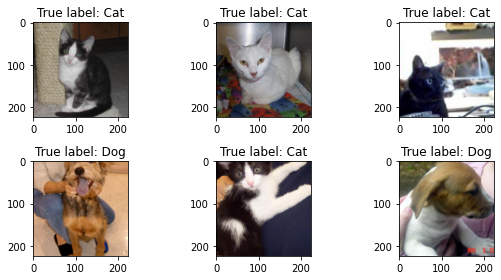

In [38]:
C, H, W = oTrainSet[0][0].shape
fig, _     = plt.subplots(2, 3, figsize=(8, 4))
for ax in fig.axes:
    idx   = np.random.randint(0, len(oTrainSet))
    mX, y = oTrainSet[idx]
    mX    = mX * vStd[:,None,None] + vMean[:,None,None] #-- unnormalizing
    mX    = torch.clamp(mX, 0, 1)
    ax.imshow(np.transpose(mX.numpy(), (1,2,0)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

In [39]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

In [41]:
def GetModel():
    oModel = torchvision.models.resnet50(pretrained=True)
    for mParam in oModel.parameters():
        mParam.requires_grad = False
        
    dIn = oModel.fc.in_features
    oModel.fc = nn.Sequential(
        nn.Linear(dIn, 128), nn.ReLU(),
        nn.Linear(128, 2)
    )
    
    return oModel

In [44]:
Loss   = nn.CrossEntropyLoss()
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

In [45]:
from DeepLearningFramework_Solution.Training import TrainClassficationModel

nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oModel     = GetModel   ().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR (oOptim, max_lr=1e-2, total_steps=nIter)

lHistory   = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

ModuleNotFoundError: ignored